/home/lamarr/projects/rewoc/.venv/rewoc/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/lamarr/projects/rewoc/.venv/rewoc/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


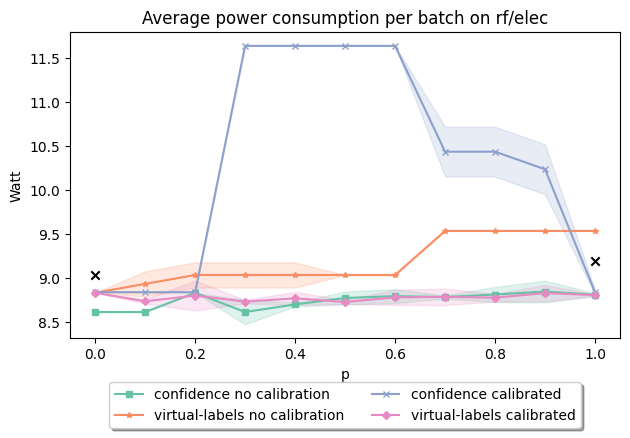

/home/lamarr/projects/rewoc/.venv/rewoc/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/lamarr/projects/rewoc/.venv/rewoc/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


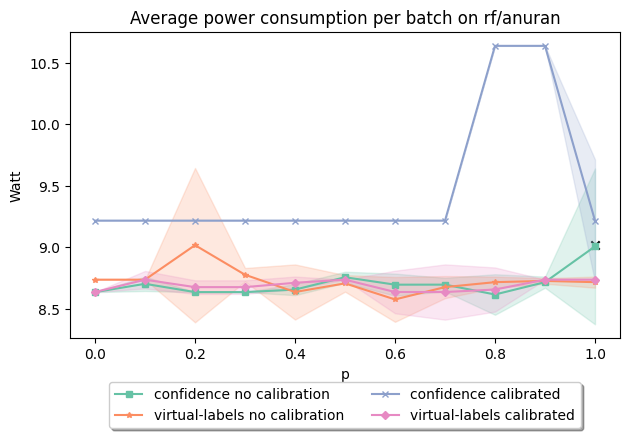

/home/lamarr/projects/rewoc/.venv/rewoc/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/lamarr/projects/rewoc/.venv/rewoc/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


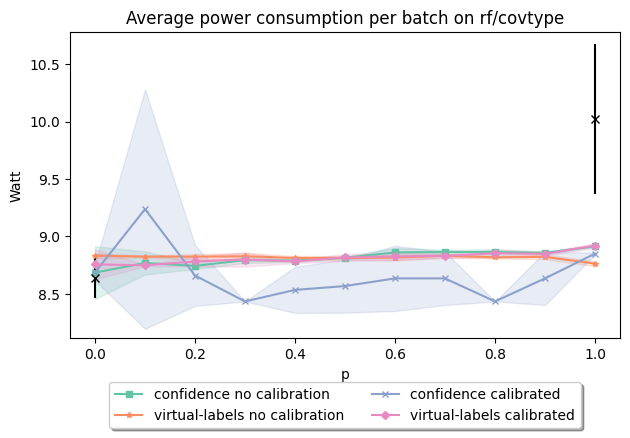

/home/lamarr/projects/rewoc/.venv/rewoc/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/lamarr/projects/rewoc/.venv/rewoc/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


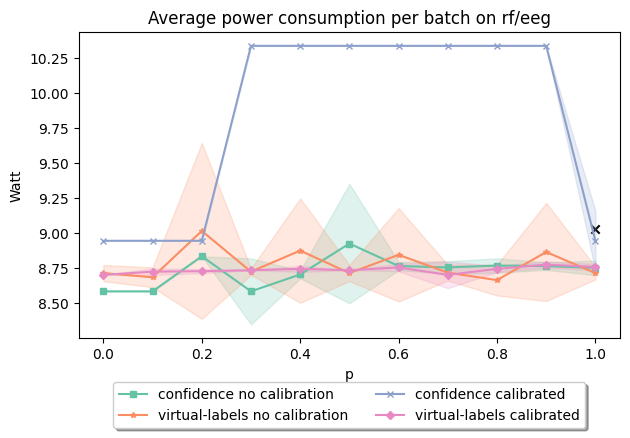

/home/lamarr/projects/rewoc/.venv/rewoc/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/lamarr/projects/rewoc/.venv/rewoc/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


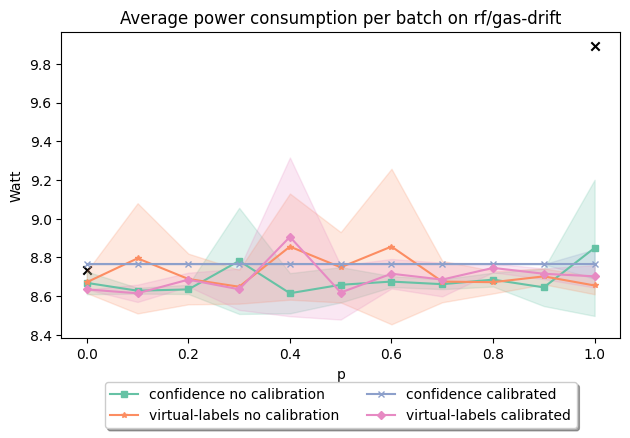

/home/lamarr/projects/rewoc/.venv/rewoc/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/lamarr/projects/rewoc/.venv/rewoc/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


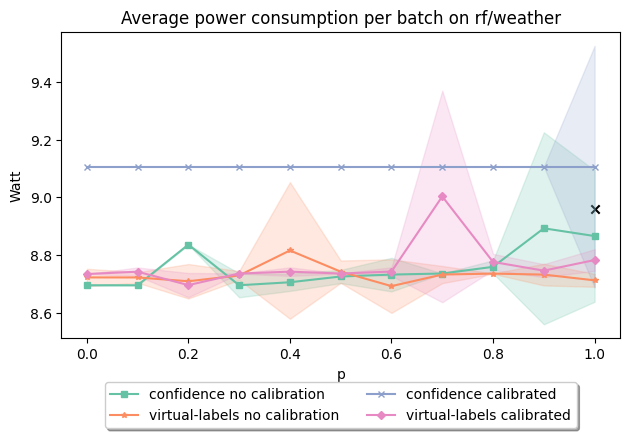

/home/lamarr/projects/rewoc/.venv/rewoc/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/lamarr/projects/rewoc/.venv/rewoc/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


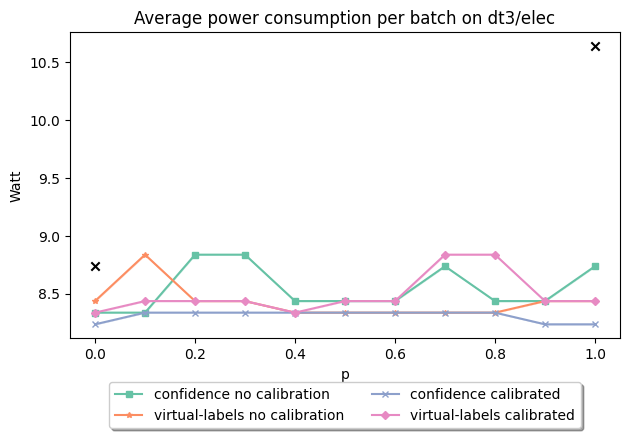

/home/lamarr/projects/rewoc/.venv/rewoc/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/lamarr/projects/rewoc/.venv/rewoc/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


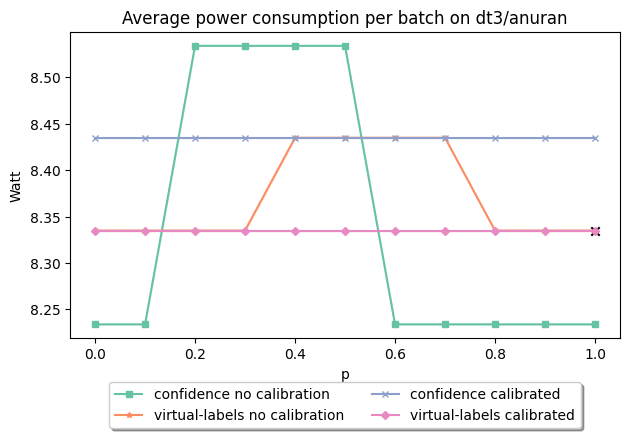

/home/lamarr/projects/rewoc/.venv/rewoc/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/lamarr/projects/rewoc/.venv/rewoc/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


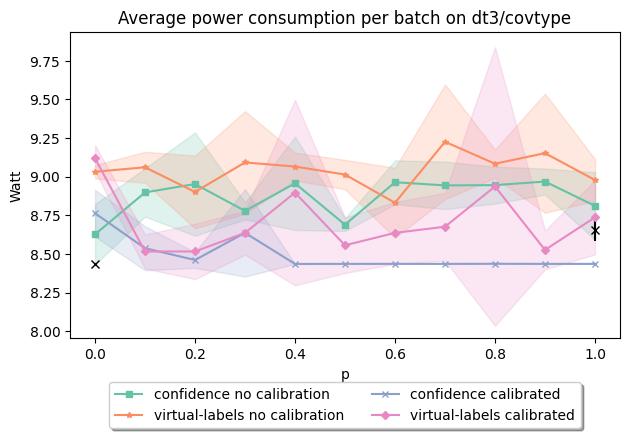

/home/lamarr/projects/rewoc/.venv/rewoc/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/lamarr/projects/rewoc/.venv/rewoc/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


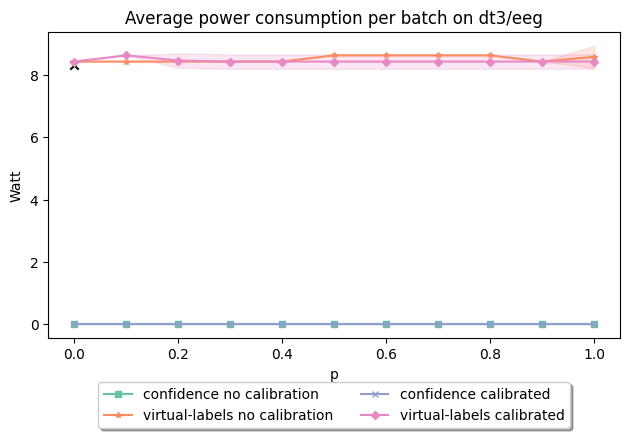

/home/lamarr/projects/rewoc/.venv/rewoc/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/lamarr/projects/rewoc/.venv/rewoc/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


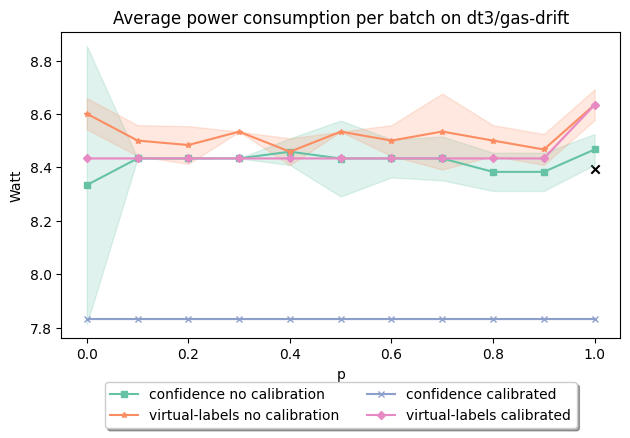

/home/lamarr/projects/rewoc/.venv/rewoc/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/lamarr/projects/rewoc/.venv/rewoc/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


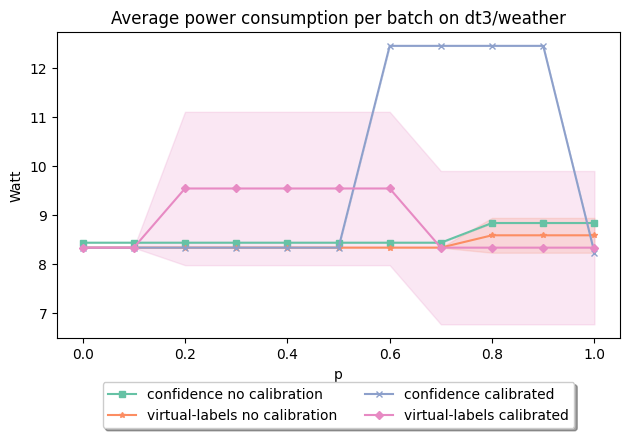

/tmp/ipykernel_42089/2000893910.py:90: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([ymin-ymin*0.01, ymax+ymax*0.01])


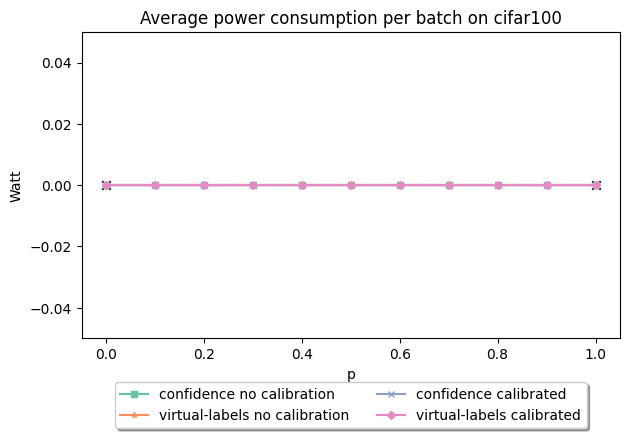

FileNotFoundError: [Errno 2] No such file or directory: 'imagenet.json'

In [9]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
from matplotlib.patches import PathPatch
from matplotlib.path import Path
plt.rcParams['text.usetex'] = False

def draw_error_band(ax, x, y, err, **kwargs):
    # Calculate normals via centered finite differences (except the first point
    # which uses a forward difference and the last point which uses a backward
    # difference).
    dx = np.concatenate([[x[1] - x[0]], x[2:] - x[:-2], [x[-1] - x[-2]]])
    dy = np.concatenate([[y[1] - y[0]], y[2:] - y[:-2], [y[-1] - y[-2]]])
    l = np.hypot(dx, dy)
    nx = dy / l
    ny = -dx / l

    # end points of errors
    xp = x + nx * err
    yp = y + ny * err
    xn = x - nx * err
    yn = y - ny * err

    vertices = np.block([[xp, xn[::-1]],
                         [yp, yn[::-1]]]).T
    codes = np.full(len(vertices), Path.LINETO)
    codes[0] = codes[len(xp)] = Path.MOVETO
    path = Path(vertices, codes)
    ax.add_patch(PathPatch(path, **kwargs))

def plot_key(df, key, markers, colors, ax, show_legend = True, x_scale = 1):
    ysmall = df[(df["model"] == "small") & (df["batch"] == True)][key]["mean"].values[0]
    ysmall_std = df[(df["model"] == "small") & (df["batch"] == True)][key]["std"].values[0]
    ybig = df[(df["model"] == "big") & (df["batch"] == True)][key]["mean"].values[0]
    ybig_std = df[(df["model"] == "big") & (df["batch"] == True)][key]["std"].values[0]

    if ysmall_std > 0 and ybig_std > 0:
        ax.errorbar([0, 1*x_scale], [ysmall, ybig], yerr = [ysmall_std, ybig_std], c = "k", fmt='x')
    else:
        ax.scatter([0, 1*x_scale], [ysmall, ybig], c = "k", marker='x')
    
    plot_number = 0
    legend_entries = []
    
    ymax = ybig_std + ybig
    ymin = ysmall - ysmall_std
    for c in df["calibration"].dropna().unique():
        for tm in df["train_method"].dropna().unique():
            x = df[(df["model"] == "RE") & (df["batch"] == True) & (df["train_method"] == tm) & (df["calibration"] == c) ]["p"]
            y = df[(df["model"] == "RE") & (df["batch"] == True) & (df["train_method"] == tm) & (df["calibration"] == c) ][key]["mean"]
            yerr = df[(df["model"] == "RE") & (df["batch"] == True) & (df["train_method"] == tm) & (df["calibration"] == c) ][key]["std"]

            x = x * x_scale
            legend_entries.append(f"{tm} {'no calibration' if not c else 'calibrated'}")
            
            yerr = np.array(yerr)
            y = np.array(y)
            for i in range(len(y)):
                if i == 0 and np.isnan(y[i]):
                    tmp = [yi for yi in y if not np.isnan(yi)]
                    y[i] = np.amin(tmp) if len(tmp) > 0 else 0
                elif i > 0 and np.isnan(y[i]):
                    y[i] = y[i-1]

                if i == 0 and np.isnan(yerr[i]):
                    yerr[i] = 0
                elif i > 0 and np.isnan(yerr[i]):
                    yerr[i] = yerr[i-1]
            yerr = np.array(yerr)
            y = np.array(y)
            
            if show_legend:
                ax.plot(x, y , color=colors[plot_number], marker=markers[plot_number], label=f"{tm} {'no calibration' if not c else 'calibrated'}", markersize=4)
            else:
                ax.plot(x, y , color=colors[plot_number], marker=markers[plot_number], markersize=4)

            if key == "p_per_batch":
                yerr = df[(df["model"] == "RE") & (df["batch"] == True) & (df["train_method"] == tm) & (df["calibration"] == c) ]["p_per_batch_std"]["mean"]
                
            ax.fill_between(x, y - yerr, y + yerr, color=colors[plot_number], alpha=0.2)
            ymax = max(ymax, np.amax(y+yerr))
            ymin = min(ymin, np.amin(y-yerr))

            plot_number = plot_number+1 if plot_number+1 < len(colors) else 0
            # plt.show()

    if not (np.isnan(ymin) or np.isinf(ymin) or np.isnan(ymax) or np.isinf(ymax)):
        ax.set_ylim([ymin-ymin*0.01, ymax+ymax*0.01])
    return legend_entries

def read_json(json_path):
    metrics = json.load(open(json_path,"r"))

    df_metrics = [{
        "model":m["model"],
        "rejector":m["rejector"],
        "run":m["run"],
        "batch":m["batch"],
        "p":m["p"],
        "p_per_batch":m["p_per_batch"],
        "train_method":m["train_method"],
        "calibration":m["calibration"],
        "f1 macro":m["f1 macro"],
        "f1 micro":m["f1 micro"],
        "accuracy":m["accuracy"],
        "time":np.mean(m["time"]),
        "power":np.mean(m["power_per_batch"]),
        "poweravg":np.mean(m["poweravg_per_batch"])
    } for m in metrics]

    df = pd.DataFrame(df_metrics)
    # display(df)
    df["p_per_batch_std"] = df["p_per_batch"].apply(lambda x: np.std(x))
    df["p_per_batch"] = df["p_per_batch"].apply(lambda x: np.mean(x))

    def batch_failed(row):
        p = row["p"]
        return 1 if row["p_per_batch"] > p else 0

    df["failed_batches"] = df.apply(batch_failed, axis=1)
    agg = {
        "time":['mean','std'],
        "f1 macro":['mean','std'],
        "f1 micro":['mean','std'],
        "accuracy":['mean','std'],
        "power":['mean','std'],
        "poweravg":['mean','std'],
        "p_per_batch":['mean','std'],
        "p_per_batch_std":['mean','std'],
        "failed_batches":['mean','std'],
    }

    df = df.groupby(["model", "rejector", "p", "batch", "train_method", "calibration"], dropna=False).agg(agg)
    df.reset_index(inplace=True)
    df["power"] = df["power"] / 1000
    df["poweravg"] = df["poweravg"] / 1000
    return df, agg.keys()

# all_files = [os.path.join("dt3", "anuran.json")] 
# all_files = [os.path.join("dt3", f) for f in os.listdir("dt3") if os.path.join("dt3", f) and f.endswith(".json") ] 
all_files = [os.path.join("rf", f) for f in os.listdir("rf") if os.path.join("rf", f) and f.endswith(".json") ] + [os.path.join("dt3", f) for f in os.listdir("dt3") if os.path.join("dt3", f) and f.endswith(".json") ] + ["cifar100.json", "imagenet.json"]

for p in all_files:
    df, agg_keys = read_json(p)
    name = p.split(".")[0]

    # display(df)
    colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3']
    markers = ["s", "*", "x", "D"]

    for m in df["rejector"].dropna().unique():
        dff = df[ (df["rejector"] == m) | (df["rejector"].isna()) ]
        # for key in agg_keys:
        # "f1 macro", "f1 micro", 
        for key in ["power"]:
        # for key in ["accuracy", "time", "power"]:
            plot_key(dff, key, markers, colors, plt.gca(), show_legend = True)
            if key == "accuracy":
                plt.title(f"Test accuracy on {name}")
                plt.ylabel(f"Accuracy")
            elif key == "poweravg" or key == "power":
                plt.title(f"Average power consumption per batch on {name}")
                plt.ylabel(f"Watt")
            else:    
                plt.title(f"{key} on {name}")
            plt.xlabel("p")
            # Add a legend to the figure
            plt.legend(loc='upper center',  bbox_to_anchor=(0.5, -0.12), shadow=True, ncol=2)
            # Adjust the layout to make space for the legend
            plt.tight_layout(rect=[0, 0, 1, 0.95])
            plt.show()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


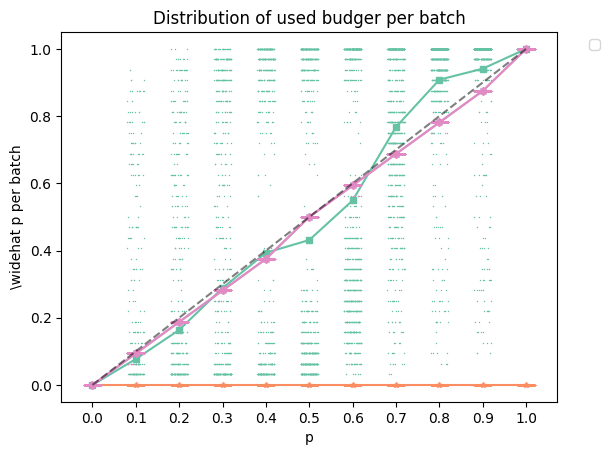

In [12]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
from matplotlib.patches import PathPatch
from matplotlib.path import Path
import seaborn as sns
plt.rcParams['text.usetex'] = False

# Define a custom aggregation function to merge lists
def merge_lists(x):
    # return x.values[0]
    merged_list = []
    for sublist in x:
        merged_list.extend(sublist)
    return merged_list

def plot_distribution(dff, ax, cal_unique, train_unique, markers, colors):
    plot_number = 0

    for c in cal_unique:
        for tm in train_unique:
            #print(f"RE {tm} {'no calibration' if not c else 'calibrated'}")
            ps = dff[(dff["model"] == "RE") & (dff["batch"] == True) & (dff["train_method"] == tm) & (dff["calibration"] == c) ]["p"]
            ymean = []
            all_y = []
            all_x = []
            for pi in ps:
                y = dff[(dff["model"] == "RE") & (dff["batch"] == True) & (dff["train_method"] == tm) & (dff["calibration"] == c) & (dff["p"] == pi)]["p_per_batch"].values[0]
                x = [pi for _ in range(len(y))]
                all_x.extend(x)
                all_y.extend(y)
                ymean.append(np.mean(y))
            
            if len(all_x) > 10_000:
                idx = np.random.choice(range(len(all_x)), size=10_000, replace=False)
            else:
                idx = range(len(all_x))

            all_x = np.array(all_x)[idx]
            all_y = np.array(all_y)[idx]
            sns.stripplot(x=all_x, y=all_y, jitter=0.2, size=1,ax=ax, color=colors[plot_number])
            # ax.scatter(all_x, all_y, c = colors[plot_number], marker=markers[plot_number], zorder=2, alpha=0.3,  s=2)
            ax.plot(ax.get_xticks(), ymean, c = colors[plot_number], marker=markers[plot_number], zorder=2,  markersize=4)
            plot_number = plot_number+1 if plot_number+1 < len(colors) else 0
        
    x = ax.get_xticks()
    y = [xi / max(x) for xi in x]
    ax.plot(x,y, c="k", linestyle="--", alpha=0.5, zorder=3)
    #ax.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), color='red', linestyle='--')


def read_grouped(json_path):
    metrics = json.load(open(json_path,"r"))

    # Group by specified columns and aggregate
    df = pd.DataFrame(metrics)
    dff = df.groupby(["model", "rejector", "p", "batch", "train_method", "calibration"]).agg({
        'p_per_batch': merge_lists,
    }).reset_index()

    return dff

colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3']
markers = ["s", "*", "x", "D"]
dff = read_grouped("backup/imagenet.json")

for rejector in dff["rejector"].dropna().unique():
    plt.xlabel("p")
    plt.ylabel("\widehat p per batch")
    plt.title(f"Distribution of used budger per batch")
    # plt.title(f"Distribution on P with rejector {rejector}")
    plot_distribution(dff, plt.gca(), dff["calibration"].dropna().unique(), dff["train_method"].dropna().unique(), markers, colors)

    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.show()

# tmp = pd.DataFrame(metrics).groupby(["model", "rejector", "p", "batch", "train_method", "calibration"], dropna=False)["p_per_batch"]

# tmp

NameError: name 'read_grouped' is not defined

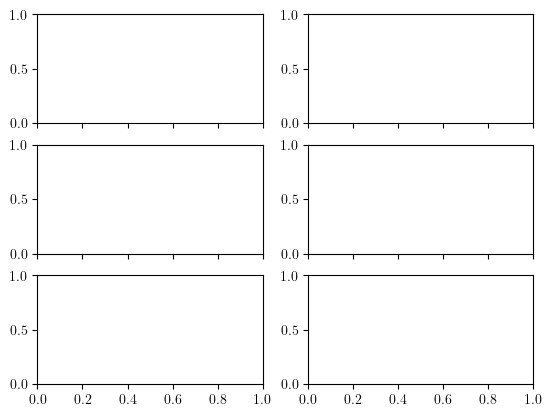

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
plt.rcParams['text.usetex'] = True

fig, axs = plt.subplots(3, 2, sharex=True)
colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3']
markers = ["s", "*", "x", "D"]
for i,jpath in enumerate(["backup/cifar100.json", "backup/imagenet.json"]):
    df,_ = read_json(jpath)
    df_distribution = read_grouped(jpath)

    legend_labels = plot_key(df, "accuracy", markers, colors, axs[0,i], show_legend = i == 0, x_scale=10)
    plot_key(df, "power", markers, colors, axs[1,i], show_legend = False, x_scale=10)
    # plot_key(df, "p_per_batch", markers, colors, axs[2,i], show_legend = False)
    plot_distribution(df_distribution, axs[2,i], df["calibration"].dropna().unique(), df["train_method"].dropna().unique(), markers, colors)

    if i == 0:
        axs[0,i].set_ylabel("Test accuracy [\%]")
        axs[0,i].yaxis.set_label_coords(-0.2, 0.5)
        axs[1,i].set_ylabel("Power [W]")
        axs[1,i].yaxis.set_label_coords(-0.2, 0.5)
        axs[2,i].set_ylabel(r"$\widehat p$ per batch [\%]")
        axs[2,i].yaxis.set_label_coords(-0.2, 0.5)


# Set titles for each column
axs[0, 0].set_title('CIFAR100')
axs[0, 1].set_title('ImageNet')

# Add a legend to the figure
fig.legend(loc='upper center',  bbox_to_anchor=(0.5, 0), shadow=True, ncol=2)

# Adjust the layout to make space for the legend
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save the figure to a PDF
with PdfPages('cifar100_imagenet.pdf') as pdf:
    pdf.savefig(fig, bbox_inches='tight')

plt.show()

/home/lamarr/projects/rewoc/.venv/rewoc/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/lamarr/projects/rewoc/.venv/rewoc/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/lamarr/projects/rewoc/.venv/rewoc/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/lamarr/projects/rewoc/.venv/rewoc/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/lamarr/projects/rewoc/.venv/rewoc/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/lamarr/projects/rewoc/.venv/rewoc/lib/python3.

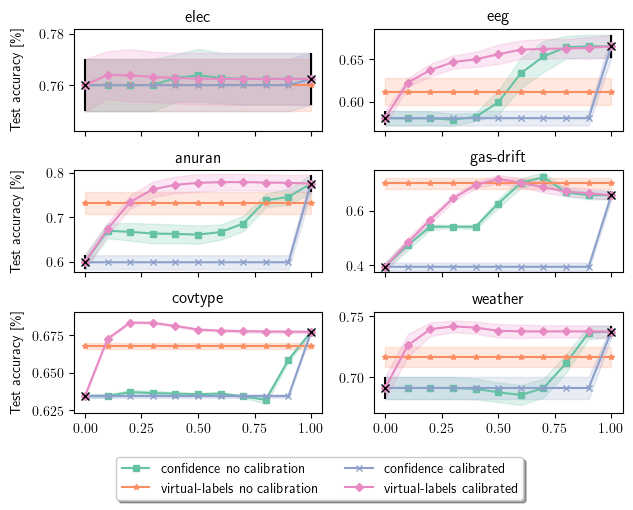

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
plt.rcParams['text.usetex'] = True

fig, axs = plt.subplots(3, 2, sharex=True)
colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3']
markers = ["s", "*", "x", "D"]
all_files = [os.path.join("backup/dt3", f) for f in os.listdir("backup/dt3") if os.path.join("backup/dt3", f) and f.endswith(".json") ]

for i,jpath in enumerate(all_files):
    df,_ = read_json(jpath)
    df_distribution = read_grouped(jpath)

    if i < 3:
        legend_labels = plot_key(df, "accuracy", markers, colors, axs[i,0], show_legend = i == 0)
        axs[i, 0].set_title(jpath.split("backup/dt3/")[1].split(".json")[0])
    else:
        legend_labels = plot_key(df, "accuracy", markers, colors, axs[i % 3,1], show_legend = i == 0)
        axs[i % 3, 1].set_title(jpath.split("backup/dt3/")[1].split(".json")[0])

    if i == 0:
        axs[0,i].set_ylabel("Test accuracy [\%]")
        axs[0,i].yaxis.set_label_coords(-0.2, 0.5)
        axs[1,i].set_ylabel("Test accuracy [\%]")
        axs[1,i].yaxis.set_label_coords(-0.2, 0.5)
        axs[2,i].set_ylabel("Test accuracy [\%]")
        axs[2,i].yaxis.set_label_coords(-0.2, 0.5)

# Add a legend to the figure
fig.legend(loc='upper center',  bbox_to_anchor=(0.5, 0), shadow=True, ncol=2)

# Adjust the layout to make space for the legend
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save the figure to a PDF
with PdfPages('dt3.pdf') as pdf:
    pdf.savefig(fig, bbox_inches='tight')

plt.show()

/home/lamarr/projects/rewoc/.venv/rewoc/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/lamarr/projects/rewoc/.venv/rewoc/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/lamarr/projects/rewoc/.venv/rewoc/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/lamarr/projects/rewoc/.venv/rewoc/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


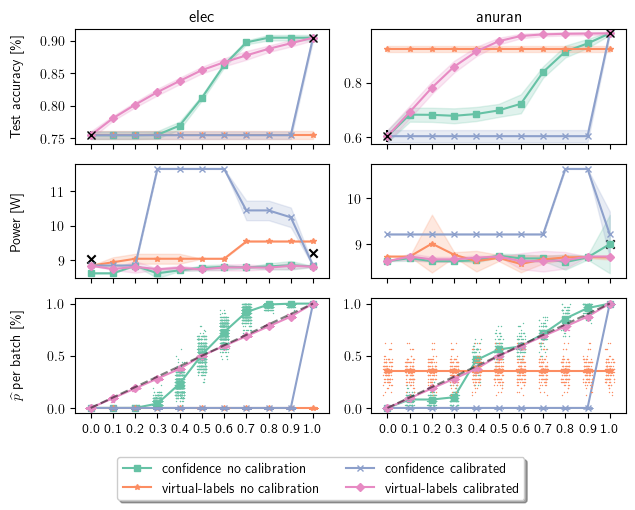

/home/lamarr/projects/rewoc/.venv/rewoc/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/lamarr/projects/rewoc/.venv/rewoc/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/lamarr/projects/rewoc/.venv/rewoc/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/lamarr/projects/rewoc/.venv/rewoc/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


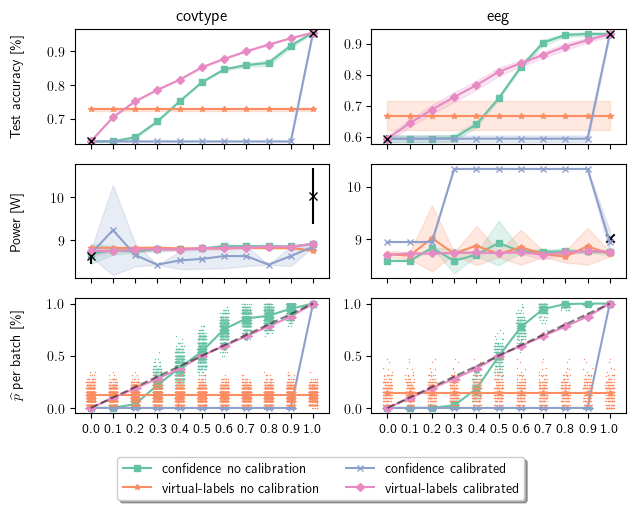

/home/lamarr/projects/rewoc/.venv/rewoc/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/lamarr/projects/rewoc/.venv/rewoc/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/lamarr/projects/rewoc/.venv/rewoc/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/lamarr/projects/rewoc/.venv/rewoc/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


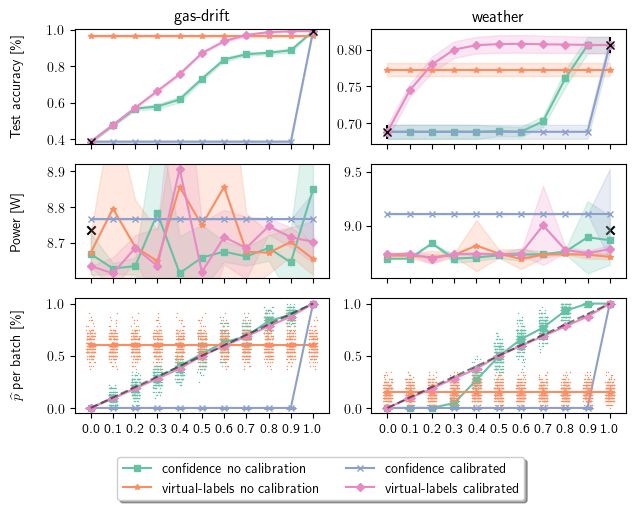

/home/lamarr/projects/rewoc/.venv/rewoc/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/lamarr/projects/rewoc/.venv/rewoc/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/lamarr/projects/rewoc/.venv/rewoc/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/lamarr/projects/rewoc/.venv/rewoc/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


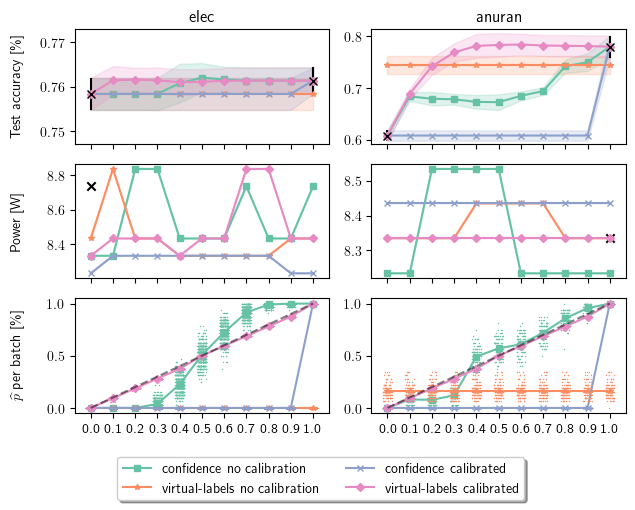

/home/lamarr/projects/rewoc/.venv/rewoc/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/lamarr/projects/rewoc/.venv/rewoc/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/lamarr/projects/rewoc/.venv/rewoc/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/lamarr/projects/rewoc/.venv/rewoc/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


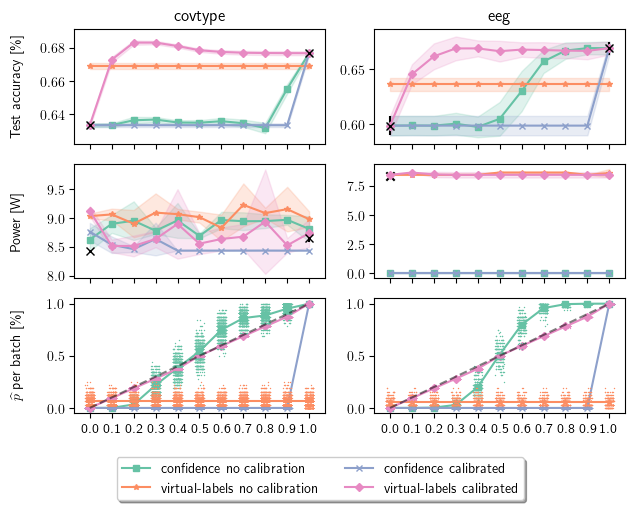

/home/lamarr/projects/rewoc/.venv/rewoc/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/lamarr/projects/rewoc/.venv/rewoc/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/lamarr/projects/rewoc/.venv/rewoc/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/lamarr/projects/rewoc/.venv/rewoc/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


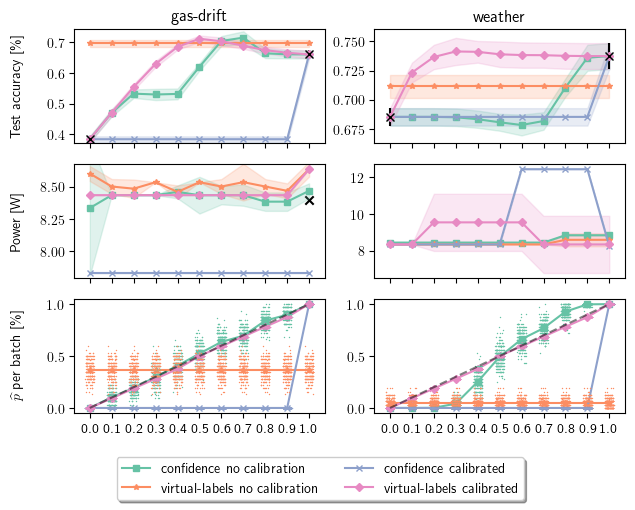

In [14]:
import os
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
plt.rcParams['text.usetex'] = True

colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3']
markers = ["s", "*", "x", "D"]

for base in ["rf", "dt3"]:
    all_files = [os.path.join(base, f) for f in os.listdir(os.path.join(base)) if f.endswith(".json") ]

    for j in range(0, len(all_files), 2):
        fig, axs = plt.subplots(3, 2, sharex=True)
        
        files = all_files[j:j+2]
        for i,jpath in enumerate(files):
            df,_ = read_json(jpath)
            df_distribution = read_grouped(jpath)

            legend_labels = plot_key(df, "accuracy", markers, colors, axs[0,i], show_legend = i == 0, x_scale=10)
            plot_key(df, "power", markers, colors, axs[1,i], show_legend = False, x_scale=10)
            # plot_key(df, "p_per_batch", markers, colors, axs[2,i], show_legend = False)
            plot_distribution(df_distribution, axs[2,i], df["calibration"].dropna().unique(), df["train_method"].dropna().unique(), markers, colors)

            if i == 0:
                axs[0,i].set_ylabel("Test accuracy [\%]")
                axs[0,i].yaxis.set_label_coords(-0.2, 0.5)
                axs[1,i].set_ylabel("Power [W]")
                axs[1,i].yaxis.set_label_coords(-0.2, 0.5)
                axs[2,i].set_ylabel(r"$\widehat p$ per batch [\%]")
                axs[2,i].yaxis.set_label_coords(-0.2, 0.5)


        # Set titles for each column
        axs[0, 0].set_title(os.path.basename(files[0]).split(".")[0])
        axs[0, 1].set_title(os.path.basename(files[1]).split(".")[0])

        # Add a legend to the figure
        fig.legend(loc='upper center',  bbox_to_anchor=(0.5, 0), shadow=True, ncol=2)

        # Adjust the layout to make space for the legend
        plt.tight_layout(rect=[0, 0, 1, 0.95])

        # Save the figure to a PDF
        with PdfPages(f'block{j}_{base}.pdf') as pdf:
            pdf.savefig(fig, bbox_inches='tight')

        plt.show()

In [ ]:
for rejector in df["rejector"].dropna().unique():
    plt.xlabel("p")
    plt.ylabel("p per batch")
    plt.title(f"Distribution on P with rejector {rejector}")
    plt.plot([0,1],[0,1], c="k", linestyle="--")
    plot_number = 0
    for m in metrics:
        c = m["calibration"]
        tm = m["train_method"]

        # These scatter plots only make sense in the batch setting
        if m["batch"] and m["run"] == 0:
            y = m["p_per_batch"]
            x = [m["p"] for _ in range(len(m["p_per_batch"]))]
            
            plt.scatter(x, y, c = colors[0], label=f"RE {tm} {'no calibration' if not c else 'calibrated'}", marker='x', s=1.5)
            plot_number = plot_number+1 if plot_number+1 < len(colors) else 0
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.show()
    asd

# for rejector in df["rejector"].dropna().unique():
#     x_rewoc_batch = []
#     y_rewoc_batch = []
#     x_re_batch = []
#     y_re_batch = []

#     x_rewoc_realtime = []
#     y_rewoc_realtime = []
#     x_re_realtime = []
#     y_re_realtime = []

#     data = []
#     for m in metrics:
#         data.append({
#             "model":m["model"],
#             "run":m["run"],
#             "batch":m["batch"],
#             "rejector":m["rejector"],
#             "p":m["p"],
#             "y": np.mean(m["p_per_batch"]),
#             "y_std":np.std(m["p_per_batch"])
#         })


#     df = pd.DataFrame(data)
#     agg = {
#         "y":['mean'],
#         "y_std":['mean'],
#     }

#     dff = df.groupby(["model", "rejector", "p", "batch", "train_method", "calibration"], dropna=False).agg(agg)
#     dff.reset_index(inplace=True)

#     # display(dff)
#     re_p_batch = dff[(dff["model"] == "RE") & (dff["batch"] == True)]["p"]
#     re_mean_batch = dff[(dff["model"] == "RE") & (dff["batch"] == True)]["y"]["mean"]
#     re_std_batch = dff[(dff["model"] == "RE") & (dff["batch"] == True)]["y_std"]["mean"]
#     rewoc_p_batch = dff[(dff["model"] == "REwOC") & (dff["batch"] == True)]["p"]
#     rewoc_mean_batch = dff[(dff["model"] == "REwOC") & (dff["batch"] == True)]["y"]["mean"]
#     rewoc_std_batch = dff[(dff["model"] == "REwOC") & (dff["batch"] == True)]["y_std"]["mean"]

#     re_p_realtime = dff[(dff["model"] == "RE") & (dff["batch"] == False)]["p"]
#     re_mean_realtime = dff[(dff["model"] == "RE") & (dff["batch"] == False)]["y"]["mean"]
#     re_std_realtime = dff[(dff["model"] == "RE") & (dff["batch"] == False)]["y_std"]["mean"]
#     rewoc_p_realtime = dff[(dff["model"] == "REwOC") & (dff["batch"] == False)]["p"]
#     rewoc_mean_realtime = dff[(dff["model"] == "REwOC") & (dff["batch"] == False)]["y"]["mean"]
#     rewoc_std_realtime = dff[(dff["model"] == "REwOC") & (dff["batch"] == False)]["y_std"]["mean"]

#     plt.title(f"Distribution of Ps with rejector {rejector}")
#     plt.plot(re_p_batch.values, re_mean_batch.values, color=colors[0], label="RE (batch)")
#     plt.fill_between(re_p_batch, np.maximum(0, re_mean_batch - re_std_batch), np.minimum(1, re_mean_batch + re_std_batch), color=colors[0], alpha=0.2)

#     plt.plot(re_p_realtime, re_mean_realtime , color=colors[2], label="RE (realtime)")
#     plt.fill_between(re_p_realtime, np.maximum(0, re_mean_realtime - re_std_realtime), np.minimum(1, re_mean_realtime + re_std_realtime), color=colors[2], alpha=0.2)

#     plt.plot(rewoc_p_batch, rewoc_mean_batch, color=colors[1], label="REwOC (batch)")
#     plt.fill_between(rewoc_p_batch, np.maximum(0, rewoc_mean_batch - rewoc_std_batch), np.minimum(1, rewoc_mean_batch + rewoc_std_batch), color=colors[1], alpha=0.2)

#     plt.plot(rewoc_p_realtime, rewoc_mean_realtime, color=colors[3], label="REwOC (realtime)")
#     plt.fill_between(rewoc_p_realtime, np.maximum(0, rewoc_mean_realtime - rewoc_std_realtime), np.minimum(1, rewoc_mean_realtime + rewoc_std_realtime), color=colors[3], alpha=0.2)

#     plt.legend(loc='upper left')
#     plt.show()

    # display(df)
    # asd

        # if m["batch"] == b:
        #     if m["rejector"] == rejector and m["model"] == "RE":
        #         if not m["run"] in data:
        #             data[m["run"]] = {
        #             }
        #         else:
        #             if m["p"] not in data[m["run"]]:
        #                 data[m["run"]][m["p"]] = []
        #             tmp = (~(np.array(m["p_per_batch"]) <= m["p"])).astype(int)
        #             data[m["run"]][m["p"]].extend(tmp)
                    #data[m["run"]][m["p"]] = m["p"]
    # for run in data:
    #     for p in data[run]:
    #         data[run][p] = np.mean(data[run][p])
    # x = []
    # y = []
    # yerr = []
    # for p in sorted(data[0].keys()):
    #     x.append(p)
    #     tmp = []
    #     for k in data.keys():
    #         tmp.append(data[k][p])
    #     y.append(np.mean(tmp))
    #     yerr.append(np.std(tmp))
    
    # y = np.array(y)
    # yerr = np.array(yerr)
    # plt.xlabel("p")
    # plt.ylabel("Percentage of failed batches")
    # plt.title(f"Percetange of batches with failed budget and rejector {rejector}")
    # plt.plot(x, y, c = "b")
    # plt.fill_between(x, y - yerr, y + yerr, color='blue', alpha=0.2)
    # plt.show()

In [ ]:
# Define a custom aggregation function to merge lists
def merge_lists(x):
    merged_list = []
    for sublist in x:
        merged_list.extend(sublist)
    return merged_list

def plot_distribution(dff, ax, cal_unique, train_unique, markers, colors):
    ax.plot([0,1],[0,1], c="k", linestyle="--", alpha=0.5, zorder=1)
    ax.set_xticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
    plot_number = 0

    for c in cal_unique:
        for tm in train_unique:
            #print(f"RE {tm} {'no calibration' if not c else 'calibrated'}")
            ps = dff[(dff["model"] == "RE") & (dff["batch"] == True) & (dff["train_method"] == tm) & (dff["calibration"] == c) ]["p"]
            y = [dff[(dff["model"] == "RE") & (dff["batch"] == True) & (dff["train_method"] == tm) & (dff["calibration"] == c) & (dff["p"] == pi)]["p_per_batch"].values[0] for pi in ps]
            if plot_number == 0:
                cur_plot = ax.boxplot(y, positions=[pi - 0.06 for pi in ps], manage_ticks=False, widths=0.02, patch_artist=True, zorder=2, notch=True, meanline=False, showmeans=False,showfliers=False)
                for patch in cur_plot["boxes"]:
                    patch.set_facecolor(colors[plot_number])
            elif plot_number == 1:
                cur_plot = ax.boxplot(y, positions=[pi - 0.02 for pi in ps], manage_ticks=False, widths=0.02, patch_artist=True, zorder=2, notch=True, meanline=False, showmeans=False,showfliers=False)
                for patch in cur_plot["boxes"]:
                    patch.set_facecolor(colors[plot_number])
            elif plot_number == 2:
                cur_plot = ax.boxplot(y, positions=[pi + 0.02 for pi in ps], manage_ticks=False, widths=0.02, patch_artist=True, zorder=2, notch=True, meanline=False, showmeans=False,showfliers=False)
                for patch in cur_plot["boxes"]:
                    patch.set_facecolor(colors[plot_number])
            elif plot_number == 3:
                cur_plot = ax.boxplot(y, positions=[pi + 0.06 for pi in ps], manage_ticks=False, widths=0.02, patch_artist=True, zorder=2, notch=True, meanline=False, showmeans=False,showfliers=False)
                for patch in cur_plot["boxes"]:
                    patch.set_facecolor(colors[plot_number])

                
            # for pi in ps:
            #     x = [pi for _ in range(len(y))]
            #     ax.boxplot()
            #     ax.scatter(x, y, c = colors[plot_number], marker=markers[plot_number], s=1, zorder=2)
            plot_number = plot_number+1 if plot_number+1 < len(colors) else 0
    N = 40
    plt.gca().margins(x=0)
    plt.gcf().canvas.draw()
    tl = plt.gca().get_xticklabels()
    maxsize = max([t.get_window_extent().width for t in tl])
    m = 0.2 # inch margin
    s = maxsize/plt.gcf().dpi*N+2*m
    margin = m/plt.gcf().get_size_inches()[0]

    plt.gcf().subplots_adjust(left=margin, right=1.-margin)
    plt.gcf().set_size_inches(s, plt.gcf().get_size_inches()[1])

def read_grouped(json_path):
    metrics = json.load(open(json_path,"r"))

    # Group by specified columns and aggregate
    df = pd.DataFrame(metrics)
    dff = df.groupby(["model", "rejector", "p", "batch", "train_method", "calibration"]).agg({
        'p_per_batch': merge_lists,
    }).reset_index()

    return dff

dff = read_grouped("imagenet.json")

for rejector in dff["rejector"].dropna().unique():
    plt.xlabel("p")
    plt.ylabel("\widehat p per batch")
    plt.title(f"Distribution of used budger per batch")
    # plt.title(f"Distribution on P with rejector {rejector}")
    plot_distribution(dff, plt.gca(), df["calibration"].dropna().unique(), df["train_method"].dropna().unique(), markers, colors)
    
    plt.legend(labels= ["1","2"], bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.show()

# tmp = pd.DataFrame(metrics).groupby(["model", "rejector", "p", "batch", "train_method", "calibration"], dropna=False)["p_per_batch"]

# tmp